In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
import japanize_matplotlib
import gc
from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK,space_eval

In [2]:
train=pd.read_csv('train_feat1.csv',index_col=0)
test=pd.read_csv('test_feat1.csv',index_col=0)

In [6]:
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)
X_test=test.drop(['id','rent'],axis=1)

In [4]:
def rmse(y_true,y_pred):
    return np.log(mean_squared_error(y_true,y_pred))

In [11]:
params = {
    'max_bin' : 63,
    'n_estimators' : 1000,
    'learning_rate': 0.01,
    'min_data_in_leaf' : 50,
    'num_leaves' : 100,
    'sparse_threshold' : 1.0,
    'device' : 'cpu',
    'save_binary': True,
    'seed' : 42,
    'feature_fraction_seed': 42,
    'bagging_seed' : 42,
    'drop_seed' : 42,
    'data_random_seed' : 42,
    'objective' : 'regression',
    'boosting_type' : 'gbdt',
    'verbose' : 0,
    'metric' : 'auc',
    'is_unbalance' : True,
    'boost_from_average' : False,
}

In [25]:
splits = 5
folds = KFold(n_splits=splits)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="l2",
            early_stopping_rounds=100,
            verbose= 500)
    
    del X_trn, y_trn
    
    val=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds=reg.predict(X_test)/splits
    del reg, X_val
    print('RMSE accuracy: {}'.format(rmse(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	training's l2: 1.88545e+10	valid_1's auc: 1	valid_1's l2: 1.99465e+10
RMSE accuracy: 23.716320470045567
fold completed in 1.5756521224975586s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	training's l2: 1.91551e+10	valid_1's auc: 1	valid_1's l2: 1.87362e+10
RMSE accuracy: 23.65372249336421
fold completed in 1.237673044204712s
** Training fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	training's l2: 1.91677e+10	valid_1's auc: 1	valid_1's l2: 1.86919e+10
RMSE accuracy: 23.651357627786766
fold completed in 1.2352588176727295s
** Training fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 1	training's l2: 1.911

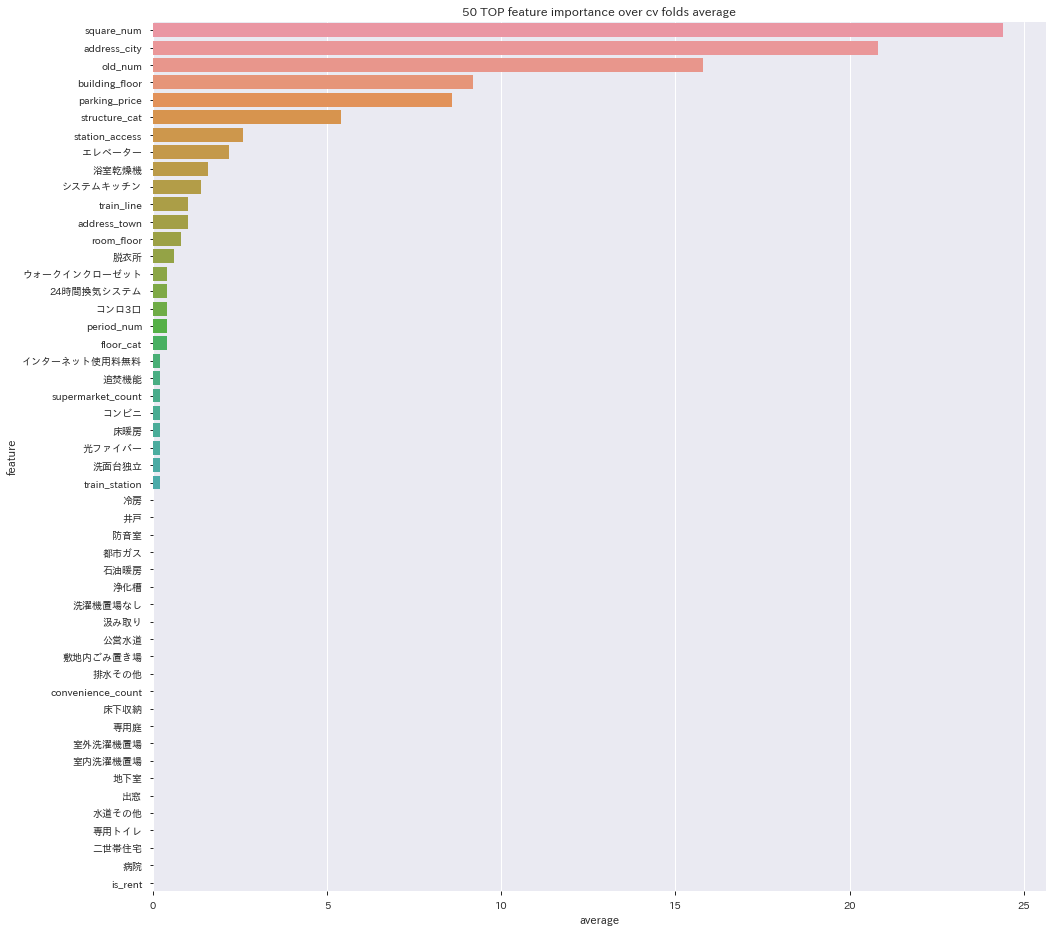

In [15]:
feature_importances['average'] = feature_importances.mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');

In [30]:
splits=5
folds =KFold(n_splits=splits)

def objective(space):
    print ('='*30 + 'New Run' + '='*30)
    rmse_scores = np.zeros(5)
    ## Do cross validation
    for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
        reg = lgb.LGBMRegressor(n_estimators = 1000,
                                tree_method= 'gpu_hist',
                                max_depth = int(space['max_depth']),
                                min_child_weight = space['min_child_weight'],
                                subsample = space['subsample'],
                                num_leaves = space['num_leaves'],
                                feature_fraction = space['feature_fraction'],
                                max_delta_step = space['max_delta_step'],
                                colsample_bytree = 0.8,
                                importance_type = 'weight'
                               )
    
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
        y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
        eval_set  = [(X_trn,y_trn), (X_val, y_val)]

        reg.fit(X_trn, y_trn,
            eval_set=eval_set, eval_metric="l2",
            early_stopping_rounds=100,
            verbose= False)
        
        del X_trn, y_trn, eval_set
        gc.collect()
        
        pred = reg.predict(X_val)
        auc = rmse(y_val, pred)      
        rmse_scores[fold_n] = auc
        print ("Score for fold {}: {}".format(fold_n+1, auc))        
        
        del pred, auc, reg
        gc.collect()
        
    print ("**Average AUC across all folds: {}".format(rmse_scores.mean()))
    return{'loss':rmse_scores.mean(), 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.8, 1),
        'num_leaves': hp.choice('num_leaves', list(range(20, 100, 10))),
        'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
        'max_delta_step': hp.quniform ('max_delta_step', 1, 10, 1)}

In [33]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

==============================New Run==============================
Score for fold 1: 22.53469569204805                 
Score for fold 2: 22.366966702589362                
Score for fold 3: 22.346955016998685                
Score for fold 4: 22.4025684299205                  
Score for fold 5: 22.387562464644148                
**Average AUC across all folds: 22.407749661240153  
==============================New Run==============================          
Score for fold 1: 22.53077504626104                                          
Score for fold 2: 22.362414631069893                                         
Score for fold 3: 22.342352013197125                                         
Score for fold 4: 22.398173102036406                                         
Score for fold 5: 22.382983899018498                                         
**Average AUC across all folds: 22.403339738316596                           
==============================New Run============================== 

Score for fold 1: 22.53069241840844                                           
Score for fold 2: 22.362320991027644                                          
Score for fold 3: 22.342275162843098                                          
Score for fold 4: 22.39809578043192                                           
Score for fold 5: 22.382880540622303                                          
**Average AUC across all folds: 22.40325297866668                             
==============================New Run==============================           
Score for fold 1: 22.53374467864386                                           
Score for fold 2: 22.365836114184454                                          
Score for fold 3: 22.34579743845409                                           
Score for fold 4: 22.401478342983534                                          
Score for fold 5: 22.386442060569735                                          
**Average AUC across all folds: 22.406659726967135  

**Average AUC across all folds: 22.40031334138642                             
100%|██████████| 30/30 [06:55<00:00, 13.87s/it, best loss: 22.400311709213213]


In [36]:
best_params = space_eval(space, best)
print (best_params)

{'feature_fraction': 0.798126399203105, 'max_delta_step': 10.0, 'max_depth': 10.0, 'min_child_weight': 7.0, 'num_leaves': 60, 'subsample': 0.9438934650393279}


In [40]:
best_params={'feature_fraction': 0.798126399203105, 'max_delta_step': 10.0, 'max_depth': 10
            , 'min_child_weight': 7.0, 'num_leaves': 60, 'subsample': 0.9438934650393279}
reg = lgb.LGBMRegressor(**best_params, 
                        n_estimators = 1000,
                        tree_method= 'gpu_hist',
                        colsample_bytree = 0.8)
reg.fit(X_train,Y_train)
prediction_opt= reg.predict(X_test)

In [49]:
sub=pd.read_csv('../input/sample_submit.csv',header=None)
sub[1]=prediction_opt

In [50]:
sub.to_csv('feat1_lighgbm.csv',header=False, index=False)